In [1]:
!pip install meteostat

In [54]:
from google.colab import drive
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as sps
from meteostat import Stations, Hourly

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler


In [4]:
# Google colab mount

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Weather Data Collection - New Brunswick
# Pulls one year of hourly temperature and humidity data from the nearest weather station in New Brunswick.
# It resamples the data to daily averages and saves it to Google Drive.
# ---------------------------------------------------------------------------------------------------------------------------

latitude = 40.4862  # New Brunswick
longitude = -74.4518
end = datetime.now()
start = end - timedelta(days=365)

stations = Stations().nearby(latitude, longitude)
station = stations.fetch(1)
station_id = station.index[0]
print(f"Using station: {station_id}")

# Fetch hourly data
data = Hourly(station_id, start, end).fetch()
data = data[["temp", "rhum"]]  # Removed wind speed

# Reset and aggregate to daily
data.reset_index(inplace=True)
daily = data.resample('D', on='time').mean().round(2)
daily = daily.rename(columns={
    "temp": "temp_avg",
    "rhum": "humidity"
})

# Save and preview
data.to_csv("/content/drive/My Drive/wildfire/new_brunswick_weather_data.csv", index=False)
print("Weather data saved")
print(data.head())


Using station: KLDJ0


Weather data saved
                 time  temp  rhum
0 2024-03-31 01:00:00  10.5  71.0
1 2024-03-31 02:00:00  10.0  77.0
2 2024-03-31 03:00:00  10.0  77.0
3 2024-03-31 04:00:00   9.2  83.0
4 2024-03-31 05:00:00   9.0  83.0


In [8]:
# Risk Grading Functions
# These functions assign a wildfire risk level based on temp, hum, CO2 thresholds.
# Risk levels range from 0 (low) to 3 (high).
# May need to change around these thresholds to tune the model better
# ---------------------------------------------------------------------------------------------------------------------------

def get_risk_level_humidity(humidity):
    if humidity < 20:
        return 3
    elif humidity < 30:
        return 2
    elif humidity < 40:
        return 1
    return 0

def get_risk_level_co2(co2):
    if co2 > 1500:
        return 3
    elif co2 > 1000:
        return 2
    elif co2 > 800:
        return 1
    return 0

def get_risk_level_temperature(temp):
    if temp > 40:
        return 3
    elif temp > 35:
        return 2
    elif temp > 30:
        return 1
    return 0


In [9]:
# Fire Flag System
# This function uses all three environmental factors to decide whether a fire flag should be raised.
# If two or more of these environmental factors are at risk level >= 1,
# a fire_flag is set to 1, signaling elevated fire danger.
# It also returns individual risk scores and a recommended action.
# ---------------------------------------------------------------------------------------------------------------------------

def raise_fire_flag(humidity, temperature, co2):
    risk_humidity = get_risk_level_humidity(humidity)
    risk_temp = get_risk_level_temperature(temperature)
    risk_co2 = get_risk_level_co2(co2)

    risk_flags = sum([
        risk_humidity >= 1,
        risk_temp >= 1,
        risk_co2 >= 1
    ])

    fire_flag = 1 if risk_flags >= 2 else 0
    action = "increase sampling + switch to complex ML model" if fire_flag else "normal monitoring"
    return fire_flag, risk_humidity, risk_temp, risk_co2, action

def process_dataset(df):
    results = df.apply(lambda row: raise_fire_flag(
        row["humidity"], row["temperature"], row.get("co2", 0)
    ), axis=1)
    df[["fire_flag", "risk_humidity", "risk_temp", "risk_co2", "action"]] = pd.DataFrame(results.tolist(), index=df.index)
    return df


Classifier Evaluation on Simulated Wildfire Conditions:

              precision  recall  f1-score  support
2                  0.23    0.70      0.35     27.0
3                  0.58    0.15      0.24     73.0
accuracy           0.30    0.30      0.30      0.3
macro avg          0.41    0.43      0.30    100.0
weighted avg       0.49    0.30      0.27    100.0
The Accuracy of Logistic Regression on New Brunswick Data is 30.0 %


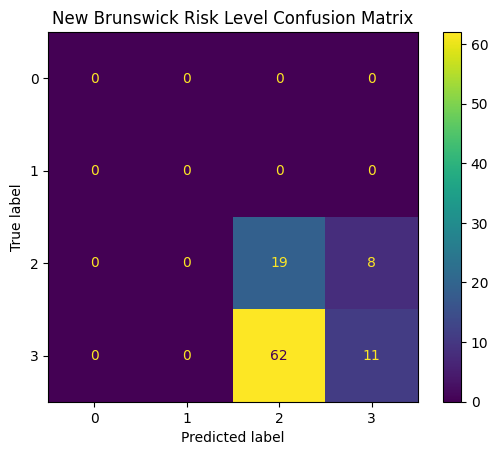

In [24]:
# Load New Brunswick Weather Data + Preprocess
# Loads the weather data, applies the fire flag system, calculates total risk level,
# scales the features, and prepares them for model training.
# ---------------------------------------------------------------------------------------------------------------------------

df = pd.read_csv("/content/drive/My Drive/wildfire/new_brunswick_weather_data.csv")
df = df.rename(columns={"temp": "temperature", "rhum": "humidity"})
df["co2"] = 0  # placeholder

df = process_dataset(df)
df["risk_level"] = df["risk_humidity"] + df["risk_temp"] + df["risk_co2"]
df["risk_level"] = df["risk_level"].clip(upper=3)

# Preprocessing: scale features
scaler_nb = StandardScaler()
X_nb = scaler_nb.fit_transform(df[["temperature", "humidity"]])
y_nb = df["risk_level"]

# Generate synthetic wildfire test data
n_samples = 100
np.random.seed(42)
wildfire_test = pd.DataFrame({
    "temperature": np.random.uniform(30, 45, n_samples),
    "humidity": np.random.uniform(5, 25, n_samples),
    "co2": np.random.uniform(600, 1600, n_samples)
})
wildfire_test["risk_level"] = wildfire_test["humidity"].apply(get_risk_level_humidity)
X_test_nb = scaler_nb.transform(wildfire_test[["temperature", "humidity"]])
y_test_nb = wildfire_test["risk_level"]

# Train model
# Logistic Regression is used to classify wildfire risk level from weather data.
# The model is trained on New Brunswick data and evaluated on synthetic wildfire conditions.
# ---------------------------------------------------------------------------------------------------------------------------

model = LogisticRegression(max_iter=1000)
model.fit(X_nb, y_nb)
y_pred_nb = model.predict(X_test_nb)

report_nb = classification_report(y_test_nb, y_pred_nb, output_dict=True)
report_df_nb = pd.DataFrame(report_nb).transpose()
print("Classifier Evaluation on Simulated Wildfire Conditions:\n")
print(report_df_nb.round(2))

accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
print(f"The Accuracy of Logistic Regression on New Brunswick Data is {accuracy_nb * 100:.1f} %")

# Get unique classes from both training and test data
all_classes = np.unique(np.concatenate([y_nb, y_test_nb]))

# Display confusion matrix with all unique classes as labels
ConfusionMatrixDisplay(
    confusion_matrix(y_test_nb, y_pred_nb, labels=all_classes),  # Specify labels for confusion matrix
    display_labels=all_classes  # Specify labels for display
).plot()

plt.title("New Brunswick Risk Level Confusion Matrix")
plt.show()

SVM Classifier Evaluation on Simulated Wildfire Conditions:
              precision  recall  f1-score  support
2                  0.56    0.37      0.44    27.00
3                  0.79    0.89      0.84    73.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.67    0.63      0.64   100.00
weighted avg       0.73    0.75      0.73   100.00
The Accuracy of SVM on New Brunswick Data is 75.0 %


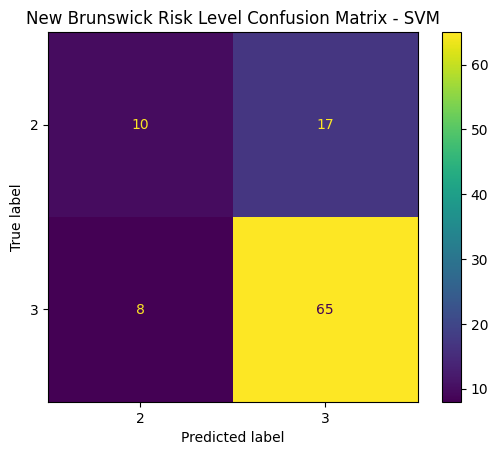

In [34]:
# SVM Model - New Brunswick Version
# ---------------------------------------------------------------------------------------------------------------------------

svm_model = SVC()
svm_model.fit(X_nb, y_nb)
y_pred_svm = svm_model.predict(X_test_nb)

report_svm = classification_report(y_test_nb, y_pred_svm, output_dict=True)
report_df_svm = pd.DataFrame(report_svm).transpose()
print("SVM Classifier Evaluation on Simulated Wildfire Conditions:")
print(report_df_svm.round(2))

accuracy_svm = accuracy_score(y_test_nb, y_pred_svm)
print(f"The Accuracy of SVM on New Brunswick Data is {accuracy_svm * 100:.1f} %")

# Get all unique classes from y_test_nb and y_pred_svm
all_classes_svm = np.unique(np.concatenate((y_test_nb, y_pred_svm)))

ConfusionMatrixDisplay(confusion_matrix(y_test_nb, y_pred_svm, labels=all_classes_svm), display_labels=all_classes_svm).plot()
plt.title("New Brunswick Risk Level Confusion Matrix - SVM")
plt.show()


Random Forest Classifier Evaluation on Simulated Wildfire Conditions:
              precision  recall  f1-score  support
2                  0.00    0.00      0.00    27.00
3                  0.73    1.00      0.84    73.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.36    0.50      0.42   100.00
weighted avg       0.53    0.73      0.62   100.00
The Accuracy of Random Forest on New Brunswick Data is 73.0 %


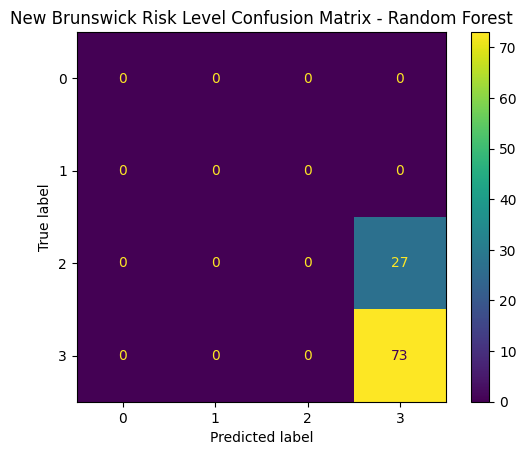

In [41]:
# Random Forest on New Brunswick Data
# ---------------------------------------------------------------------------------------------------------------------------
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_nb, y_nb)
y_pred_rf = rf_model.predict(X_test_nb)

report_rf = classification_report(y_test_nb, y_pred_rf, output_dict=True)
report_df_rf = pd.DataFrame(report_rf).transpose()
print("Random Forest Classifier Evaluation on Simulated Wildfire Conditions:")
print(report_df_rf.round(2))

accuracy_rf = accuracy_score(y_test_nb, y_pred_rf)
print(f"The Accuracy of Random Forest on New Brunswick Data is {accuracy_rf * 100:.1f} %")

# Display confusion matrix with all unique classes as labels
ConfusionMatrixDisplay(
    confusion_matrix(y_test_nb, y_pred_rf, labels=all_classes),  # Specify labels for confusion matrix
    display_labels=all_classes  # Specify labels for display
).plot()
plt.title("New Brunswick Risk Level Confusion Matrix - Random Forest")
plt.show()

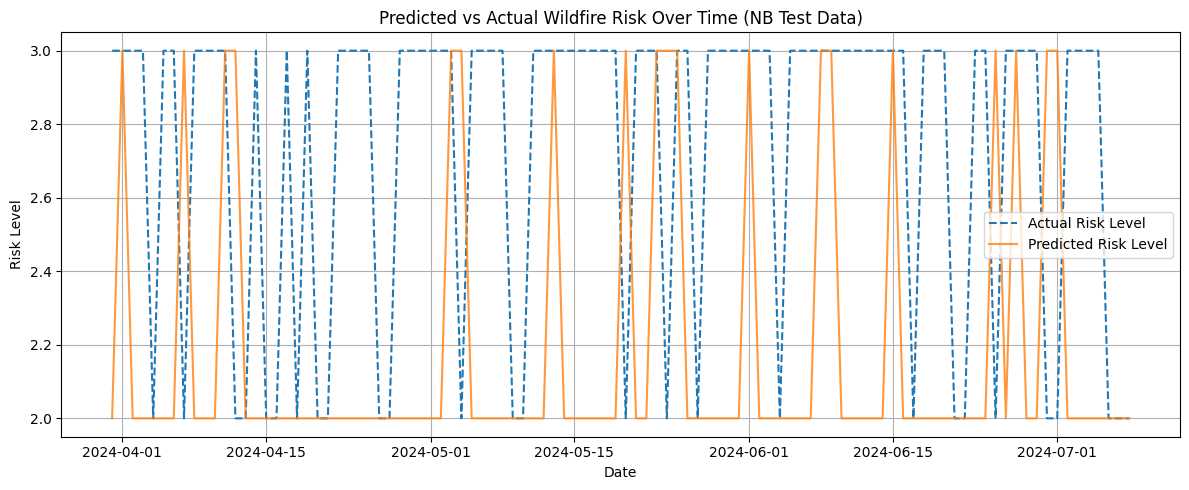

In [29]:
# Visualization: Predicted vs Actual Risk Over Time
# This plot compares the model's predicted wildfire risk level with actual labels across a timeline
# using synthetic test data.
# ---------------------------------------------------------------------------------------------------------------------------

# Add date back to the test set (match the first n_samples from the original daily data)
test_dates = daily.index.to_series().reset_index(drop=True).iloc[:n_samples]  # Access the index and convert to Series
wildfire_test_with_dates = wildfire_test.copy()
wildfire_test_with_dates["date"] = pd.to_datetime(test_dates)
wildfire_test_with_dates["actual_risk"] = y_test_nb.values
wildfire_test_with_dates["predicted_risk"] = y_pred_nb

# Plot
plt.figure(figsize=(12, 5))
plt.plot(wildfire_test_with_dates["date"], wildfire_test_with_dates["actual_risk"], label="Actual Risk Level", linestyle='--')
plt.plot(wildfire_test_with_dates["date"], wildfire_test_with_dates["predicted_risk"], label="Predicted Risk Level", alpha=0.8)
plt.title("Predicted vs Actual Wildfire Risk Over Time (NB Test Data)")
plt.xlabel("Date")
plt.ylabel("Risk Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classifier Evaluation on IoT Smoke Detection Dataset:

              precision  recall  f1-score   support
0                  0.83    0.28      0.41   4509.00
1                  0.77    0.98      0.86  11149.00
accuracy           0.78    0.78      0.78      0.78
macro avg          0.80    0.63      0.64  15658.00
weighted avg       0.79    0.78      0.73  15658.00
The Accuracy of Logistic Regression on Kaggle Smoke Detection Data is 77.5 %


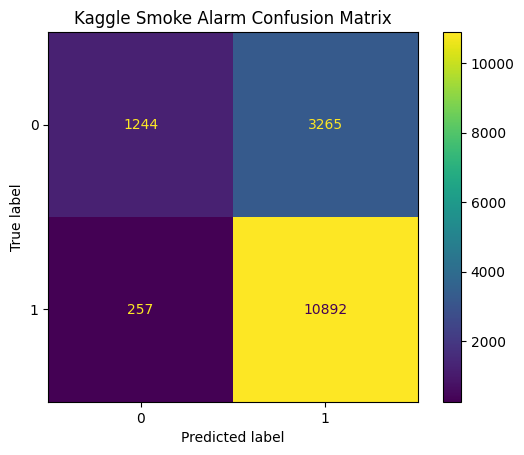

In [17]:
# Load and Use Kaggle Dataset + Preprocess
# This section loads labeled IoT smoke sensor data from Kaggle, applies the fire flag logic,
# and trains a Logistic Regression model to classify fire alarm activations.
# ---------------------------------------------------------------------------------------------------------------------------

kaggle_path = "/content/drive/My Drive/wildfire/smoke_detection_iot.csv"
kdf = pd.read_csv(kaggle_path)
kdf = kdf[["Temperature[C]", "Humidity[%]", "eCO2[ppm]", "Fire Alarm"]]
kdf.columns = ["temperature", "humidity", "co2", "fire_alarm"]

kdf = process_dataset(kdf)

scaler_k = StandardScaler()
X_k = scaler_k.fit_transform(kdf[["temperature", "humidity", "co2"]])
y_k = kdf["fire_alarm"]

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.25, random_state=42)

model_k = LogisticRegression(max_iter=1000)
model_k.fit(X_train_k, y_train_k)
y_pred_k = model_k.predict(X_test_k)

report_k = classification_report(y_test_k, y_pred_k, output_dict=True)
report_df_k = pd.DataFrame(report_k).transpose()
print("\nClassifier Evaluation on IoT Smoke Detection Dataset:\n")
print(report_df_k.round(2))

accuracy_k = accuracy_score(y_test_k, y_pred_k)
print(f"The Accuracy of Logistic Regression on Kaggle Smoke Detection Data is {accuracy_k * 100:.1f} %")

ConfusionMatrixDisplay(confusion_matrix(y_test_k, y_pred_k), display_labels=model_k.classes_).plot()
plt.title("Kaggle Smoke Alarm Confusion Matrix")
plt.show()

SVM Classifier Evaluation on IoT Smoke Detection Dataset:
              precision  recall  f1-score   support
0                  0.99    0.51      0.67   4509.00
1                  0.83    1.00      0.91  11149.00
accuracy           0.86    0.86      0.86      0.86
macro avg          0.91    0.75      0.79  15658.00
weighted avg       0.88    0.86      0.84  15658.00
The Accuracy of SVM on Kaggle Smoke Detection Data is 85.7 %


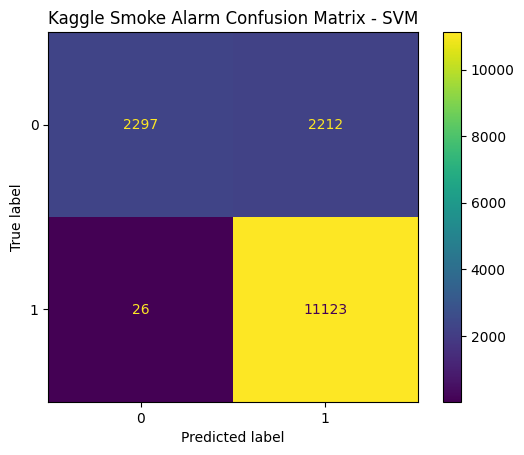

In [35]:
# SVM on Kaggle Smoke Detection Data
# ---------------------------------------------------------------------------------------------------------------------------
from sklearn.svm import SVC

svm_model_k = SVC()
svm_model_k.fit(X_train_k, y_train_k)
y_pred_svm_k = svm_model_k.predict(X_test_k)

report_svm_k = classification_report(y_test_k, y_pred_svm_k, output_dict=True)
report_df_svm_k = pd.DataFrame(report_svm_k).transpose()
print("SVM Classifier Evaluation on IoT Smoke Detection Dataset:")
print(report_df_svm_k.round(2))

accuracy_svm_k = accuracy_score(y_test_k, y_pred_svm_k)
print(f"The Accuracy of SVM on Kaggle Smoke Detection Data is {accuracy_svm_k * 100:.1f} %")

ConfusionMatrixDisplay(confusion_matrix(y_test_k, y_pred_svm_k), display_labels=svm_model_k.classes_).plot()
plt.title("Kaggle Smoke Alarm Confusion Matrix - SVM")
plt.show()

Random Forest Classifier Evaluation on IoT Smoke Detection Dataset:
              precision  recall  f1-score   support
0                  0.94    0.92      0.93   4509.00
1                  0.97    0.98      0.97  11149.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.96    0.95      0.95  15658.00
weighted avg       0.96    0.96      0.96  15658.00
The Accuracy of Random Forest on Kaggle Smoke Detection Data is 96.2 %


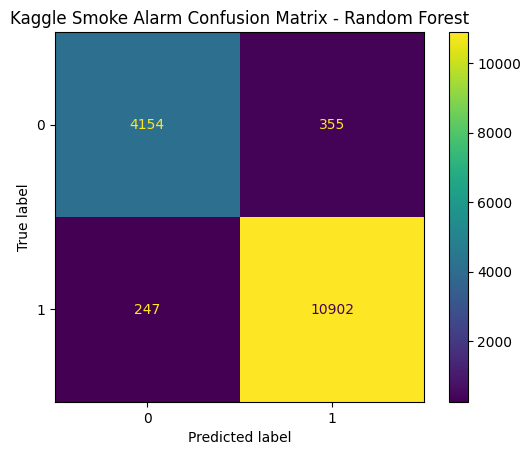

In [42]:
# Random Forest on Kaggle Smoke Detection Data
# ---------------------------------------------------------------------------------------------------------------------------
rf_model_k = RandomForestClassifier(random_state=42)
rf_model_k.fit(X_train_k, y_train_k)
y_pred_rf_k = rf_model_k.predict(X_test_k)

report_rf_k = classification_report(y_test_k, y_pred_rf_k, output_dict=True)
report_df_rf_k = pd.DataFrame(report_rf_k).transpose()
print("Random Forest Classifier Evaluation on IoT Smoke Detection Dataset:")
print(report_df_rf_k.round(2))

accuracy_rf_k = accuracy_score(y_test_k, y_pred_rf_k)
print(f"The Accuracy of Random Forest on Kaggle Smoke Detection Data is {accuracy_rf_k * 100:.1f} %")

ConfusionMatrixDisplay(confusion_matrix(y_test_k, y_pred_rf_k), display_labels=rf_model_k.classes_).plot()
plt.title("Kaggle Smoke Alarm Confusion Matrix - Random Forest")
plt.show()

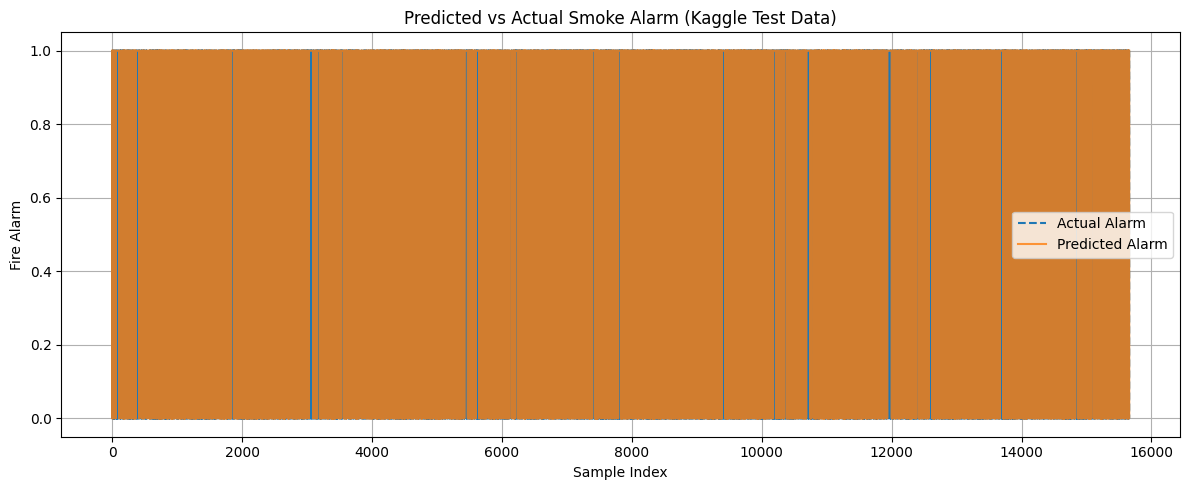

In [36]:
# Visualization: Kaggle Fire Alarm Prediction Over Samples
# This plot compares the predicted and actual fire alarm values for the Kaggle test set.
# The x-axis represents the sample index.
# ---------------------------------------------------------------------------------------------------------------------------


# Create a simple index-based x-axis
kdf_vis = pd.DataFrame({
    "index": np.arange(len(y_test_k)),
    "actual_alarm": y_test_k.reset_index(drop=True),
    "predicted_alarm": y_pred_k
})

plt.figure(figsize=(12, 5))
plt.plot(kdf_vis["index"], kdf_vis["actual_alarm"], label="Actual Alarm", linestyle='--')
plt.plot(kdf_vis["index"], kdf_vis["predicted_alarm"], label="Predicted Alarm", alpha=0.8)
plt.title("Predicted vs Actual Smoke Alarm (Kaggle Test Data)")
plt.xlabel("Sample Index")
plt.ylabel("Fire Alarm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
# Blended Model
# This function combines predictions from both the New Brunswick and Kaggle models.
# If either model predicts elevated risk (risk level ≥2 or fire alarm == 1), it returns a blended alert.
# A sample of predictions with model outputs is displayed.
# Still needs fine-tuning and more testing
# ---------------------------------------------------------------------------------------------------------------------------

def blended_fire_alert_logistic_regression(row):
    nb_input = scaler_nb.transform(row[["temperature", "humidity"]].values.reshape(1, -1))
    k_input = scaler_k.transform(row[["temperature", "humidity", "co2"]].values.reshape(1, -1))

    nb_pred = model.predict(nb_input)[0]
    kaggle_pred = model_k.predict(k_input)[0]
    blended = int(nb_pred >= 2 or kaggle_pred == 1)

    return pd.Series([nb_pred, kaggle_pred, blended], index=["nb_risk", "kaggle_alarm", "blended_alert"])

def blended_fire_alert_svm(row):
    nb_input = scaler_nb.transform(row[["temperature", "humidity"]].values.reshape(1, -1))
    k_input = scaler_k.transform(row[["temperature", "humidity", "co2"]].values.reshape(1, -1))

    nb_pred = svm_model.predict(nb_input)[0]
    kaggle_pred = svm_model_k.predict(k_input)[0]
    blended = int(nb_pred >= 2 or kaggle_pred == 1)

    return pd.Series([nb_pred, kaggle_pred, blended], index=["nb_risk_svm", "kaggle_alarm_svm", "blended_alert_svm"])

def blended_fire_alert_rf(row):
    nb_input = scaler_nb.transform(row[["temperature", "humidity"]].values.reshape(1, -1))
    k_input = scaler_k.transform(row[["temperature", "humidity", "co2"]].values.reshape(1, -1))

    nb_pred = rf_model.predict(nb_input)[0]
    kaggle_pred = rf_model_k.predict(k_input)[0]
    blended = int(nb_pred >= 2 or kaggle_pred == 1)

    return pd.Series([nb_pred, kaggle_pred, blended], index=["nb_risk_rf", "kaggle_alarm_rf", "blended_alert_rf"])


kdf_sample = kdf.iloc[y_test_k.index].copy()

# Logistic Regression predictions
blended_results = kdf_sample.apply(blended_fire_alert_logistic_regression, axis=1)
kdf_sample = pd.concat([kdf_sample, blended_results], axis=1)
print("Sample Blended Alerts with Model Outputs:")
print(kdf_sample[["temperature", "humidity", "co2", "nb_risk", "kaggle_alarm", "blended_alert"]])


# SVM-based blended predictions
blended_results_svm = kdf_sample.apply(blended_fire_alert_svm, axis=1)
kdf_sample = pd.concat([kdf_sample, blended_results_svm], axis=1)
print("Sample Blended Alerts with Model Outputs (SVM):")
print(kdf_sample[["temperature", "humidity", "co2", "nb_risk_svm", "kaggle_alarm_svm", "blended_alert_svm"]])

# Random Forest-based blended predictions
blended_results_rf = kdf_sample.apply(blended_fire_alert_rf, axis=1)
kdf_sample = pd.concat([kdf_sample, blended_results_rf], axis=1)
print("Sample Blended Alerts with Model Outputs (Random Forest):")
print(kdf_sample[["temperature", "humidity", "co2", "nb_risk_rf", "kaggle_alarm_rf", "blended_alert_rf"]])


Streaming output truncated to the last 5000 lines.


Sample Blended Alerts with Model Outputs:
       temperature  humidity  co2  nb_risk  kaggle_alarm  blended_alert
31120       21.330     51.93  400        0             1              1
49054       24.300     53.78  400        0             1              1
55910       43.330     18.53  400        3             0              1
33802       18.440     56.79  400        0             1              1
9683        -4.350     57.35  977        0             1              1
...            ...       ...  ...      ...           ...            ...
1413        26.346     56.40  400        0             1              1
59288        0.620     47.08  442        0             1              1
34668       21.220     61.20  956        0             1              1
53107       28.760     41.47  400        1             0              0
10827        4.406     49.50  657        0             1              1

[15658 rows x 6 columns]


Streaming output truncated to the last 5000 lines.


Sample Blended Alerts with Model Outputs (SVM):
       temperature  humidity  co2  nb_risk_svm  kaggle_alarm_svm  \
31120       21.330     51.93  400            0                 1   
49054       24.300     53.78  400            0                 1   
55910       43.330     18.53  400            3                 0   
33802       18.440     56.79  400            0                 1   
9683        -4.350     57.35  977            0                 1   
...            ...       ...  ...          ...               ...   
1413        26.346     56.40  400            0                 1   
59288        0.620     47.08  442            0                 1   
34668       21.220     61.20  956            0                 1   
53107       28.760     41.47  400            1                 0   
10827        4.406     49.50  657            0                 1   

       blended_alert_svm  
31120                  1  
49054                  1  
55910                  1  
33802                  1  


Streaming output truncated to the last 5000 lines.


KeyboardInterrupt: 

In [59]:
# More data- may or may not use it for more

# Define coordinates for New Jersey forest (example)
latitude = 40.0583
longitude = -74.4057

# Define time range
start_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")
end_date = datetime.now().strftime("%Y-%m-%d")

# Open-Meteo API URL
url = "https://archive-api.open-meteo.com/v1/archive"

# Weather variables
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": "temperature_2m,relative_humidity_2m",
    "timezone": "America/New_York"
}

response = requests.get(url, params=params)
data = response.json()

if "hourly" in data:
    df = pd.DataFrame({
        "timestamp": data["hourly"]["time"],
        "temperature": data["hourly"]["temperature_2m"],
        "humidity": data["hourly"]["relative_humidity_2m"]
    })

    # Save to Google Drive
    path = "/content/drive/My Drive/wildfire/weather_data_1yr.csv"
    df.to_csv(path, index=False)
    print(f"Data saved to: {path}")
    print(df.head())
else:
    print(" No hourly data returned:")
    print(data)

Data saved to: /content/drive/My Drive/wildfire/weather_data_1yr.csv
          timestamp  temperature  humidity
0  2024-03-31T00:00          8.4      84.0
1  2024-03-31T01:00          7.4      90.0
2  2024-03-31T02:00          6.4      91.0
3  2024-03-31T03:00          6.9      90.0
4  2024-03-31T04:00          7.2      89.0
